In [1]:
import flimview.flim as flim
import flimview.io_utils as io
import flimview.models as models
import numpy as np
import matplotlib.pyplot as plt
import flimview.plot_utils as pu
from tqdm import tnrange, tqdm_notebook, tqdm
from matplotlib import cm
import h5py
import os

In [2]:
sdtfile = 'data/epidermis.sdt'

In [3]:
data,header = io.read_sdt_file(sdtfile)

In [4]:
header

{'flimview': {'sdt_info': '*IDENTIFICATION\n  ID        : \x04SPC FCS Data File\x04\n  Title     : 34_N_760nm_c07\n  Version   : 3  966 M\n  Revision  : 8 bits ADC\n  Date      : 2019-03-05\n  Time      : 16:49:19\n  Author    : System\n  Company   : Unknown\n  Contents  : Autosaved results for cycle 7 of 40 from FIFO_IMAGE measurement\n*END\n\n',
  'filename': 'epidermis.sdt',
  'pathname': 'SDT',
  'xpix': 256,
  'ypix': 256,
  'tpix': 256,
  'tresolution': 48.86091184430619}}

In [5]:
FC = flim.FlimCube(data, header)

In [6]:
FCbin = flim.binCube(FC, bin=4, kernel='gauss')

In [7]:
#c11.mask_peak(5)
#c11_bin.mask_peak(0, mask=c11.mask)
FCbin.mask_intensity(80)
FC.mask_intensity(0, mask=FCbin.mask)

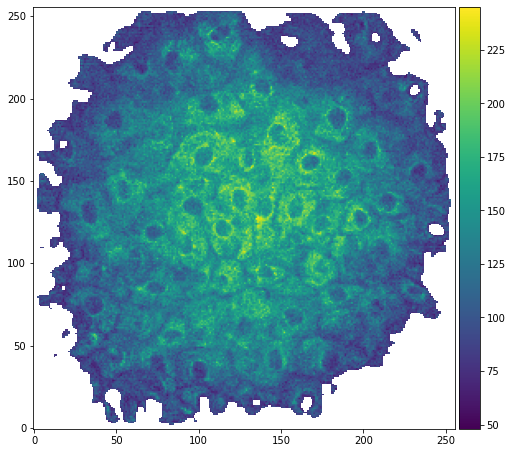

In [8]:
pu.plot2d(FC.intensity)

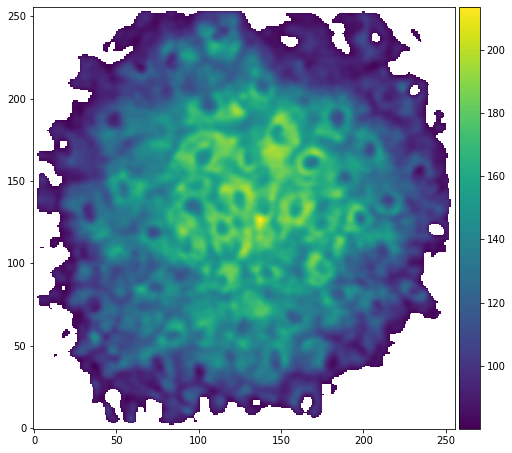

In [9]:
pu.plot2d(FCbin.intensity)

In [10]:
# Assuming a FlimCube FC, let's compute the average of the pixel values
timesteps,mean_pixel = flim.meanDecay(FCbin)
# Let's clean these by a threshold, normalize and shift to the maximum
timesteps_clean,mean_pixel_clean,max_value,time_shift = flim.cleanCurve(timesteps,mean_pixel, norm=True, threshold=0.02)
# Let's assume a model (double exponential with a level parfameter)
mymodel = models.model1
# Let's fit that mean pixel using fitPixel function
# xf,yf are the time and value used for the fitting, pfit is the fitted values, pcov is the parameters covariance matrix and chi2
# is the Chi-square value of the fit
xf,yf, pfit, pcov, chi2 = flim.fitPixel(timesteps,mean_pixel, mymodel, initial_p=[0.8, 0.3, 3, 0.03], bounds=(0, np.inf), norm=True)

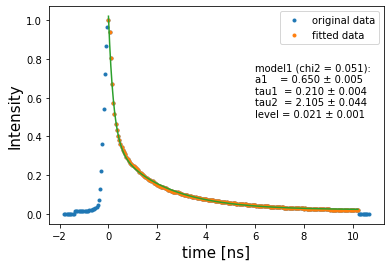

In [11]:
# We can plot the fitted data (only considering from the maximum value )
plt.plot(timesteps-time_shift, mean_pixel/max_value, '.', label='original data')
plt.plot(xf,yf,'.', label='fitted data')
plt.plot(xf,mymodel(xf, *pfit))
plt.xlabel('time [ns]', fontsize=15)
plt.ylabel('Intensity', fontsize=15)
plt.text(6, 0.5, flim.printModel(mymodel, pfit, pcov, chi2, oneliner=False))
plt.legend(loc=0)
plt.savefig('figures/mean_fit.png', bbox_inches='tight')

In [12]:
print(flim.printModel(mymodel, pfit, pcov, chi2, oneliner=False))

model1 (chi2 = 0.051): 
a1    = 0.650 ± 0.005
tau1  = 0.210 ± 0.004
tau2  = 2.105 ± 0.044
level = 0.021 ± 0.001


In [13]:
bounds0=[0.0, 0.0, 0. , 0.]
bounds1=[1, 1., 5., 1.]

### Figure 3

Text(6, 0.6, 'model1 (chi2 = 0.051): \na1    = 0.650 ± 0.005\ntau1  = 0.210 ± 0.004\ntau2  = 2.105 ± 0.044\nlevel = 0.021 ± 0.001')

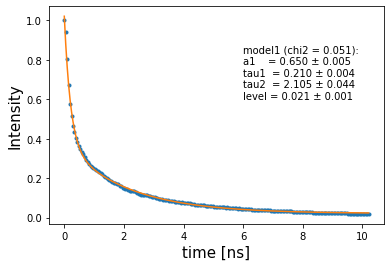

In [21]:
plt.plot(xf,yf,'.')
plt.plot(xf,mymodel(xf, *pfit))
plt.xlabel('time [ns]', fontsize=15)
plt.ylabel('Intensity', fontsize=15)
plt.text(6, 0.6, flim.printModel(mymodel, pfit, pcov, chi2, oneliner=False))
#_=plt.title(flim.printModel(mymodel, pfit, pcov, chi2, oneliner=True))
## Uncomment these line to plot
##plt.savefig('figures/mean_fit.png', bbox_inches='tight')

### Fit the data

In [15]:
# Define the boundaries for parameters
bounds_lower=[0.0, 0.0, 0. , 0.]
bounds_upper=[1, 1., 5., 1.]
# Fit  the whole cube
Ffit = flim.fitCube(
    FCbin,
    mymodel,
    pfit,
    bounds=(bounds_lower, bounds_upper),
    norm=True,
    threshold=0.02)

100%|██████████| 256/256 [03:49<00:00,  1.12it/s]


### Save output into one structured HDF5 file

In [18]:
io.saveCube(FC, group='example_sdt',filename='test_sdt.h5')

In [19]:
io.saveCube(FCbin, group='example_sdt', filename='test_sdt.h5')

In [20]:
io.saveFit(Ffit, group='example_sdt', filename='test_sdt.h5')